<a href="https://colab.research.google.com/github/s-moran/covid-19-modeling/blob/master/Covid19_Infection_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Live analysis of the growth for the COVID19 pandemic

**Update: March 18, 2020:** The US has seen a recent pickup in cases with growth rates >30% over the past 2 days, causing the peak amplitude to shift towards the population max.

**Update: March 16, 2020:** Added ability to control amplitude upperbound via pop_max parameter.

**Update: March 15, 2020:** Initial work. Predictions for US and other European countrires are unstable at this point but check back within the next few days.

**Source:** This is an update to the notebook by Enrico Ros (https://colab.research.google.com/drive/16CzLtNCnYq8x3gEBOgg2pMmDQngSD2vG). The original notebook (for Italy only) was posted in the comments to a medium article by Gianluca Malato (https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d).

**IMPORTANT DISCLAIMER**: The model projections and data shown here are subject to change as new data is released. Please use at your discretion and review the code yourself to make sure you are comfortable with it. Also note that the JHU has been experiencing technical isssues over the last couple of days so data for certain countries may not be accurate until this is resolved (see https://github.com/CSSEGISandData/COVID-19/issues/650). Despite these technical issues, the JHU dataset offers global coverage, which is convenient because it allows us to easily model different countries within the same notebook.



## Import the latest data
The data comes from the confirmed cases time series CSV file, which can be found at https://github.com/CSSEGISandData/COVID-19. 

This is the data repository for the 2019 Novel Coronavirus Visual Dashboard operated by the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE).

**Notes**: 
* The default country for the notebook is the US. This notebook can easily be run for any other country by changing the `country` variable in the code cell below.

* The data is provided at a state level and then summed across all columns to obtain the country level data. 

* The data team for JHU moved from county level reporting to state level reporting on 2020-03-10. Please see https://github.com/CSSEGISandData/COVID-19/issues/590 for more details.

*   The Github data does not always reflect the latest values available on the JHU dashboard (https://github.com/CSSEGISandData/COVID-19/issues/730)



In [0]:
#@title Select Country
# Examples: 'Iran', 'Korea, South', 'Italy', 'China', 'US', 'France, 'United Kingdom'
country = 'US'
# Upper bound for logistic amplitude (should be population of country)
pops = {
    'Italy': 60.48e6,
    'US': 327.2e6
}
pop_max = pops[country]

In [18]:
#@title { vertical-output: true, display-mode: "form" }
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rc('font', size=14)

import pandas as pd
from datetime import datetime, timedelta

# read the latest CSV file
url = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
      "csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
df = pd.read_csv(url)
df = df.rename(columns={"Province/State": "prov", 
                        "Country/Region": 'cntry'})
df = df.drop(columns=['Lat', 'Long'])

# Restrict df to selected country
df = df[df.cntry.isin([country])].T

df.columns = df.loc['prov']
if len(df.columns) == 1:
  df.columns = df.loc['cntry']

df = df.drop(index=['prov', 'cntry'])
df.index = pd.to_datetime(df.index)

# Drop data point on March 12 since seems to be erronous
# https://github.com/CSSEGISandData/COVID-19/issues/804
if country in ['Spain', 'Germany', 'France', 'Italy', 'United Kingdom']:
  df = df.drop(index=pd.to_datetime('2020-03-12'))

# U.S. level processing (no longer needed, but commented out in case we need again)
# See https://github.com/CSSEGISandData/COVID-19/issues/590
# if country == 'US':
#   # drop county level data to avoid double counting
#   county_cols = df.columns[(
#       df.columns.str.contains(',\s[A-Z]{2}')) |
#       df.columns.isin(['Grand Princess', 'Diamond Princess', 'Washington, D.C.'])]

#   # non county-level cols
#   other_cols = df.columns.difference(county_cols)

#   # Should see only 67 counts (Cruise liners) for `county_cols` after March 1st
#   print(df[county_cols].sum(axis=1).loc['2020-03-01':])
#   # Should see zero counts for `other_cols` before March 1st
#   print(df[other_cols].sum(axis=1).loc['2020-03-01':])

df.tail()

prov,Washington,New York,California,Massachusetts,Diamond Princess,Grand Princess,Georgia,Colorado,Florida,New Jersey,Oregon,Texas,Illinois,Pennsylvania,Iowa,Maryland,North Carolina,South Carolina,Tennessee,Virginia,Arizona,Indiana,Kentucky,District of Columbia,Nevada,New Hampshire,Minnesota,Nebraska,Ohio,Rhode Island,Wisconsin,Connecticut,Hawaii,Oklahoma,Utah,Kansas,Louisiana,Missouri,Vermont,Alaska,...,"Dallas, TX","Tarrant, TX","Montgomery, TX","Middlesex, NJ","Jefferson, CO","Multnomah, OR","Polk, OR","Deschutes, OR","McHenry, IL","Lake, IL","Bucks, PA","Hanover, VA","Lancaster, SC","Sullivan, TN","Johnson, IN","Howard, IN","St. Joseph, IN","Knox, NE","Stark, OH","Anoka, MN","Olmsted, MN","Summit, UT","Fairfield, CT","Litchfield, CT","Orleans, LA","Pennington, SD","Beadle, SD","Charles Mix, SD","Davison, SD","Minnehaha, SD","Bon Homme, SD","Socorro, NM","Bernalillo, NM","Oakland, MI","Wayne, MI","New Castle, DE",Alabama,Puerto Rico,Guam,Virgin Islands
2020-03-13,568,421,282,123,46,21,42,49,50,29,30,43,46,41,17,18,17,13,26,30,9,13,14,10,17,6,14,13,13,14,19,11,2,2,9,5,36,2,2,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0
2020-03-14,572,525,340,138,46,21,66,101,76,69,32,57,64,47,17,26,24,19,32,41,12,16,14,10,21,7,21,14,26,20,27,22,4,4,10,8,77,4,5,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,3,0,1
2020-03-15,643,732,426,164,46,21,99,131,115,98,36,72,93,66,18,32,33,28,39,45,13,20,20,16,24,13,35,17,37,20,32,24,6,7,28,8,91,5,8,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,5,3,1
2020-03-16,904,967,557,197,47,20,121,160,155,178,39,85,105,77,23,41,38,33,52,49,18,25,21,22,45,17,54,18,50,21,47,30,7,10,39,11,136,6,12,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29,5,3,1
2020-03-17,1076,1706,698,218,47,21,146,160,216,267,66,110,161,112,23,60,64,47,74,67,20,30,26,22,56,26,60,21,67,23,72,68,10,19,51,18,196,11,12,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39,5,3,2


In [19]:
#@title { display-mode: "form", vertical-output: true }
df = pd.DataFrame({'cases': df.sum(axis=1)}).astype('int')
df['day'] = (df.index - pd.to_datetime('2019-12-31')).days

# re-ordering of columns (important for simulations below)
df = df[['day', 'cases']]

dfG = df.copy()
dfG['cases_diff'] = df['cases'].diff()
dfG['cases_growth_%'] = 100 * df['cases'].pct_change()
print('last 7 days of aggregated US data')
dfG[-7:]

last 7 days of aggregated US data


,day,cases,cases_diff,cases_growth_%
2020-03-11,71,1281,322.0,33.576642
2020-03-12,72,1663,382.0,29.820453
2020-03-13,73,2179,516.0,31.028262
2020-03-14,74,2727,548.0,25.149151
2020-03-15,75,3499,772.0,28.309498
2020-03-16,76,4632,1133.0,32.380680
2020-03-17,77,6421,1789.0,38.622625


Growth in the last two weeks - **chart copied from [This Tweet](https://twitter.com/Francolino_Bear/status/1237227757509021697) by [Francesco Favaro](https://twitter.com/Francolino_Bear)** on 3/10/2020:

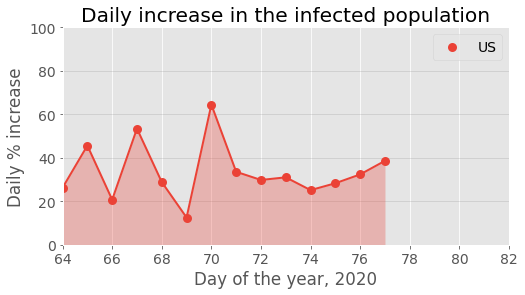

In [20]:
#@title { vertical-output: true, display-mode: "form" }
dfg2 = dfG[-14:]
x = dfg2['day'].to_list()
y = dfg2['cases_growth_%'].tolist()

plt.figure(figsize=(8, 4))
plt_axes = plt.gca()
plt_axes.grid(axis='y', color=(0.4, 0.4, 0.4), alpha=0.2)
plt.stackplot(x, y, color=(0.92, 0.26, 0.21, 0.3), linewidth=0)
plt.plot(x, y, color=(0.92, 0.26, 0.21), linewidth=2)
plt.scatter(x, y, color=(0.92, 0.26, 0.21), label=country, linewidth=3)
plt.xlim(int(min(x)), int(max(x) + 5))
plt.ylim(0, 100)
plt.title("Daily increase in the infected population")
plt.xlabel("Day of the year, 2020")
plt.ylabel("Daily % increase")
plt.legend()
plt.show()

## Predicting the size of the infection
We use a logistic model and fit it to the data. Granted that the logistic model will differ from reality, but it's an easy and explainable model that can be used for now to model the slow spread of the virus to a population. Please take note of the +/-, which provides an indication of the quality of fit. The +/- provides the one standard deviation errors on the parameters.

In [21]:
#@title { vertical-output: true, display-mode: "form" }
import numpy as np
from scipy.optimize import curve_fit, fsolve
from IPython.display import HTML as html_print


def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))


# fit the data to the model (find the model variables that best approximate)
def predict_logistic_maximum(df):
    samples = df.shape[0]
    x_days = df['day'].tolist()
    y_cases = df['cases'].tolist()
    initial_guess = 4, 100, 25000 # speed, peak, amplitude

    lbounds = [0, 0, 0]
    # Upper bound of 1 billion on amplitude
    ubounds = [np.inf, np.inf, pop_max]
    fit = curve_fit(logistic_model, 
                    x_days, y_cases, 
                    p0=initial_guess, maxfev=9999,
                    bounds=(lbounds, ubounds))

    # parse the result of the fit
    speed, x_peak, y_max = fit[0]
    speed_error, x_peak_error, y_max_error = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]

    # find the "end date", as the x (day of year) where the function reaches 99.99%
    end = int(fsolve(lambda x: logistic_model(x, speed, x_peak, y_max) - y_max * 0.9999, x_peak))

    return x_days, y_cases, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples


# print results
def print_prediction(df, label):
    x, y, speed, x_peak, y_max, x_peak_error, y_max_error, end, samples = predict_logistic_maximum(df)
    print(label + "'s prediction: " +
          "maximum cases: " + str(int(round(y_max))) +
          " (± " + str(int(round(y_max_error))) + ")" +
          ", peak at calendar day: " + str(int(round(x_peak))) +
          " (± " + str(round(x_peak_error, 2)) + ")" +
          ", ending on calendar day: " + str(end))
    return y_max


print_prediction(df[:-2], "2 days ago")
print_prediction(df[:-1], "yesterday")
pred = print_prediction(df, "today")
print()
html_print("As of today, the total infection is predicted to stabilize at <b>" + str(int(round(pred))) + "</b>")


2 days ago's prediction: maximum cases: 11998 (± 1590), peak at calendar day: 78 (± 0.65), ending on calendar day: 107
yesterday's prediction: maximum cases: 29692 (± 7848), peak at calendar day: 82 (± 1.2), ending on calendar day: 113
today's prediction: maximum cases: 325936526 (± 0), peak at calendar day: 116 (± 0.37), ending on calendar day: 149



## Live Predictions and Experiments

### Plot 1. data & projections, for today and the former 2 days

Note: Use the slider to adjust the y-axis limit on the chart

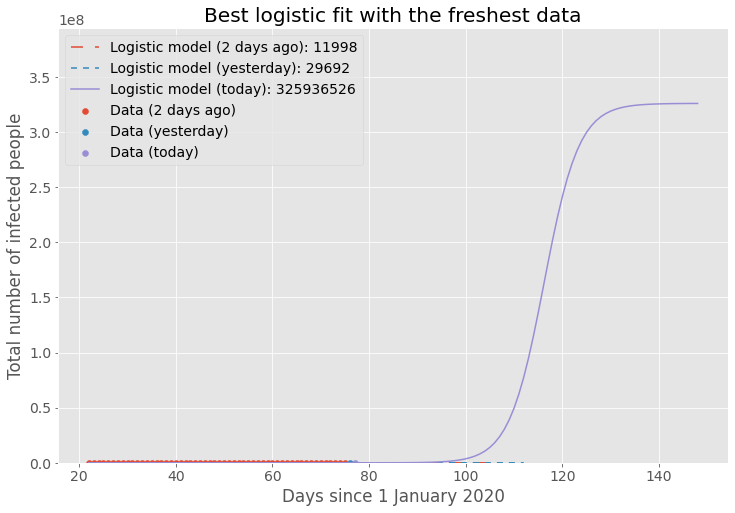

In [22]:
#@title { run: "auto", vertical-output: true, display-mode: "form" }
ymax_scaler = 1.1 #@param {type:"slider", min:0, max:15, step:0.1}

def add_real_data(df, label, color=None):
    x = df['day'].tolist()
    y = df['cases'].tolist()
    plt.scatter(x, y, label="Data (" + label + ")", c=color)


def add_logistic_curve(df, label, **kwargs):
    x, _, speed, x_peak, y_max, _, _, end, _ = predict_logistic_maximum(df)
    x_range = list(range(min(x), end))
    plt.plot(x_range,
             [logistic_model(i, speed, x_peak, y_max) for i in x_range],
             label="Logistic model (" + label + "): " + str(int(round(y_max))),
             **kwargs)
    return y_max


def label_and_show_plot(plt, title, y_max=None):
    plt.title(title)
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    if (y_max):
        plt.ylim(0, y_max * 1.1)
    plt.legend()
    plt.show()


# Plot
plt.figure(figsize=(12, 8))
add_real_data(df[:-2], "2 days ago")
add_real_data(df[-2:-1], "yesterday")
add_real_data(df[-1:], "today")
add_logistic_curve(df[:-2], "2 days ago", dashes=[8, 8])
add_logistic_curve(df[:-1], "yesterday", dashes=[4, 4])
y_max = add_logistic_curve(df, "today")
label_and_show_plot(plt, "Best logistic fit with the freshest data", ymax_scaler * y_max)

### Experiment 1: discarding noisy initial samples
Try discarding points at the beginning to see how it affects the prediction.


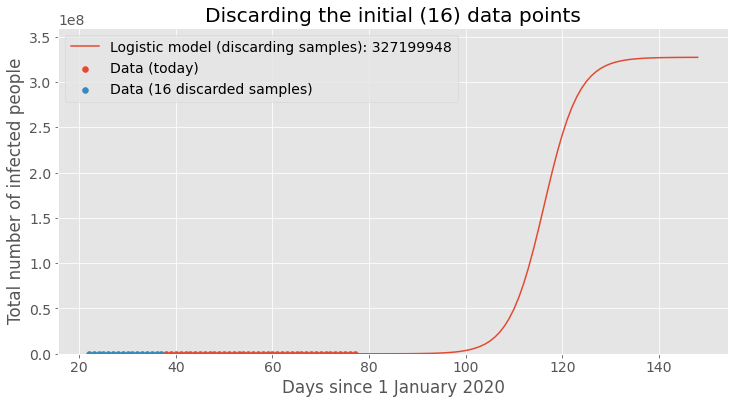

In [23]:
#@title Try it yourself { run: "auto", vertical-output: true, form-width: "620px", display-mode: "form" }
points_to_discard = 16 #@param {type:"slider", min:0, max:40, step:1}

# Plot: discard initial data points
plt.figure(figsize=(12, 6))
pts = points_to_discard
add_real_data(df[pts:], "today")
add_real_data(df[:pts], str(pts) + " discarded samples")
y_max = add_logistic_curve(df[pts:], "discarding samples")
label_and_show_plot(plt, "Discarding the initial (" + str(pts) + ") data points", y_max)

### Simulation 1: changing the growth rate of the next 5 days
Use the "last 7 days of aggregated US data" printout at the top of the notebook to come with reasonable estimates for future growth.


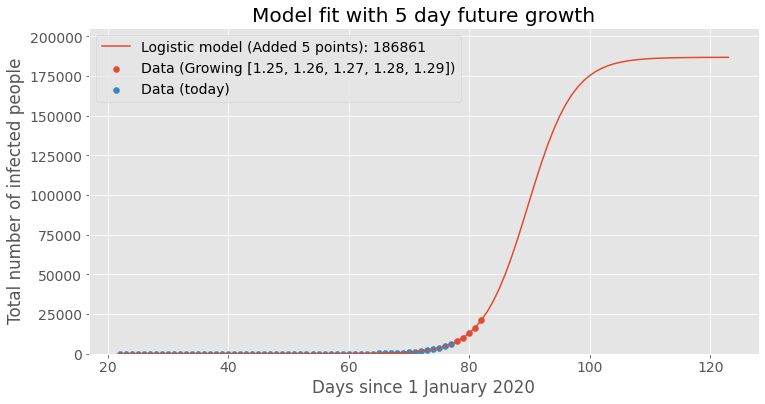

In [24]:
#@title Change future growth { run: "auto", vertical-output: true, form-width: "620px", display-mode: "form" }
#@markdown Try changing the parameters simulating the possible growth in the next few days.
#@markdown The minimum at this stage is set to 1.0 (no increases, end of the infection), and the maximum to 1.50.

tomorrow = 1.25 #@param {type:"slider", min:1, max:1.5, step:0.01}
day_plus_2 = 1.26 #@param {type:"slider", min:1, max:1.5, step:0.01}
day_plus_3 = 1.27 #@param {type:"slider", min:1, max:1.5, step:0.01}
day_plus_4 = 1.28 #@param {type:"slider", min:1, max:1.5, step:0.01}
day_plus_5 = 1.29 #@param {type:"slider", min:1, max:1.5, step:0.01}

# apply the growth
add_points = [tomorrow, day_plus_2, day_plus_3, day_plus_4, day_plus_5]
num_points = len(add_points)
dfa = df.copy()
for a in add_points:
    dfa = dfa.append(pd.Series([dfa.iloc[-1][0] + 1, int(dfa.iloc[-1][1] * a)], index=dfa.columns), ignore_index=True)

# Plot
plt.figure(figsize=(12, 6))
add_real_data(dfa[-num_points:], "Growing " + str(add_points))
add_real_data(dfa[:-num_points], "today")
y_max = add_logistic_curve(dfa, "Added " + str(num_points) + " points")
label_and_show_plot(plt, "Model fit with 5 day future growth", y_max)